In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from pyomo import environ as pe

import scheduling_abstract_model as sam

In [2]:
solver = pe.SolverFactory("glpk")

In [3]:
abstract = sam.create()

In [4]:
# Scenario 1: Each customer only overlaps with one tutor
scenario1 = abstract.create_instance(data={
    None: {
        'worker_schedules': {
            ('Adam', 'Wednesday'): 1,
            ('Bob', 'Monday'): 1,
            ('Cynthia', 'Tuesday'): 1,
        },
        'customer_requests': {
            ('Frank', 'Monday'): 1,
            ('Ginny', 'Tuesday'): 1,
            ('Hannah', 'Wednesday'): 1,
        }
    }
})

scenario1_expected_output = {
    ('Bob', 'Frank', 'Monday'),
    ('Cynthia', 'Ginny', 'Tuesday'),
    ('Adam', 'Hannah', 'Wednesday')
}

solver.solve(scenario1)

assert sam.get_assignments(scenario1) == scenario1_expected_output

In [5]:
# Scenario 2a: No assignments because one customer can't be assigned
scenario2a = abstract.create_instance(data={
    None: {
        'worker_schedules': {
            ('Adam', 'Monday'): 1,
            ('Bob', 'Tuesday'): 1,
            ('Cynthia', 'Wednesday'): 1,
        },
        'customer_requests': {
            ('Frank', 'Monday'): 1,
            ('Ginny', 'Tuesday'): 1,
            ('Hannah', 'Thursday'): 1,
        }
    }
})

scenario2a_expected_output = set()

solver.solve(scenario2a)

assert sam.get_assignments(scenario2a) == scenario2a_expected_output

In [6]:
# Scenario 2b: Same as Scenario 2a, but should only return *some* customers due to relaxing the 
#              "everybody must have somebody assigned" constraint
scenario2b = abstract.create_instance(data={
    None: {
        'worker_schedules': {
            ('Adam', 'Monday'): 1,
            ('Bob', 'Tuesday'): 1,
            ('Cynthia', 'Wednesday'): 1,
        },
        'customer_requests': {
            ('Frank', 'Monday'): 1,
            ('Ginny', 'Tuesday'): 1,
            ('Hannah', 'Thursday'): 1,
        }
    }
})
scenario2b.exactly_one_worker_per_customer.deactivate()

scenario2b_expected_output = {
    ('Adam', 'Frank', 'Monday'),
    ('Bob', 'Ginny', 'Tuesday'),
}

solver.solve(scenario2b)

assert sam.get_assignments(scenario2b) == scenario2b_expected_output

In [7]:
# Scenario 3a: More overlap between customers and workers, but still only one solution because
#              Hannah only overlaps with one worker and we're restricting each worker
#              to only one customer
scenario3a = abstract.create_instance(data={
    None: {
        'worker_schedules': {
            ('Adam', 'Sunday'): 1,
            ('Adam', 'Monday'): 1,
            ('Bob', 'Monday'): 1,
            ('Bob', 'Tuesday'): 1,
            ('Cynthia', 'Tuesday'): 1,
            ('Cynthia', 'Wednesday'): 1,
        },
        'customer_requests': {
            ('Frank', 'Monday'): 1,
            ('Ginny', 'Tuesday'): 1,
            ('Hannah', 'Wednesday'): 1,
        }
    }
})

scenario3a_expected_output = {
    ('Adam', 'Frank', 'Monday'),
    ('Bob', 'Ginny', 'Tuesday'),
    ('Cynthia', 'Hannah', 'Wednesday')
}

solver.solve(scenario3a)

assert sam.get_assignments(scenario3a) == scenario3a_expected_output

In [8]:
# Scenario 3b: Same as Scenario 3a, but we have non-uniqueness because due to relaxing the 
#              "at most one customer per worker" constraint
scenario3b = abstract.create_instance(data={
    None: {
        'worker_schedules': {
            ('Adam', 'Sunday'): 1,
            ('Adam', 'Monday'): 1,
            ('Bob', 'Monday'): 1,
            ('Bob', 'Tuesday'): 1,
            ('Cynthia', 'Tuesday'): 1,
            ('Cynthia', 'Wednesday'): 1,
        },
        'customer_requests': {
            ('Frank', 'Monday'): 1,
            ('Ginny', 'Tuesday'): 1,
            ('Hannah', 'Wednesday'): 1,
        }
    }
})
scenario3b.at_most_one_customer_per_worker.deactivate()

scenario3b_expected_outputs = {
    # One each
    frozenset({
        ('Adam', 'Frank', 'Monday'),
        ('Bob', 'Ginny', 'Tuesday'),
        ('Cynthia', 'Hannah', 'Wednesday')
    }),
    # Adam 1, Bob 0, Cynthia 2
    frozenset({
        ('Adam', 'Frank', 'Monday'),
        ('Cynthia', 'Ginny', 'Tuesday'),
        ('Cynthia', 'Hannah', 'Wednesday')
    }),
    # Adam 0, Bob 2, Cynthia 1
    frozenset({
        ('Bob', 'Frank', 'Monday'),
        ('Bob', 'Ginny', 'Tuesday'),
        ('Cynthia', 'Hannah', 'Wednesday')
    }),
    # Adam 0, Bob 1, Cynthia 2
    frozenset({
        ('Bob', 'Frank', 'Monday'),
        ('Cynthia', 'Ginny', 'Tuesday'),
        ('Cynthia', 'Hannah', 'Wednesday')
    })
}

scenario3b_all_solutions = sam.get_all_solutions(scenario3b)

assert scenario3b_all_solutions == scenario3b_expected_outputs

In [9]:
# Scenario 4a: Same as Scenario 3a but with multiple customer requests, same end answer
scenario4a = abstract.create_instance(data={
    None: {
        'worker_schedules': {
            ('Adam', 'Sunday'): 1,
            ('Adam', 'Monday'): 1,
            ('Bob', 'Monday'): 1,
            ('Bob', 'Tuesday'): 1,
            ('Cynthia', 'Tuesday'): 1,
            ('Cynthia', 'Wednesday'): 1,
        },
        'customer_requests': {
            ('Frank', 'Monday'): 1,
            ('Frank', 'Thursday'): 1,
            ('Ginny', 'Tuesday'): 1,
            ('Ginny', 'Friday'): 1,
            ('Hannah', 'Wednesday'): 1,
            ('Hannah', 'Saturday'): 1,
        }
    }
})

scenario4a_expected_output = {
    ('Adam', 'Frank', 'Monday'),
    ('Bob', 'Ginny', 'Tuesday'),
    ('Cynthia', 'Hannah', 'Wednesday')
}

solver.solve(scenario4a)

assert sam.get_assignments(scenario4a) == scenario4a_expected_output

In [10]:
# Scenario 4b: Similar as Scenario 4a but with multiple answers
scenario4b = abstract.create_instance(data={
    None: {
        'worker_schedules': {
            ('Adam', 'Sunday'): 1,
            ('Adam', 'Monday'): 1,
            ('Bob', 'Monday'): 1,
            ('Bob', 'Tuesday'): 1,
            ('Cynthia', 'Wednesday'): 1,
        },
        'customer_requests': {
            ('Frank', 'Sunday'): 1,
            ('Frank', 'Monday'): 1,
            ('Ginny', 'Monday'): 1,
            ('Ginny', 'Tuesday'): 1,
            ('Hannah', 'Tuesday'): 1,
            ('Hannah', 'Wednesday'): 1,
        }
    }
})

scenario4b_expected_outputs = {
    # Frank Sunday, Ginny Monday
    frozenset({
        ('Adam', 'Frank', 'Sunday'),
        ('Bob', 'Ginny', 'Monday'),
        ('Cynthia', 'Hannah', 'Wednesday')
    }),
    # Frank Sunday, Ginny Tuesday
    frozenset({
        ('Adam', 'Frank', 'Sunday'),
        ('Bob', 'Ginny', 'Tuesday'),
        ('Cynthia', 'Hannah', 'Wednesday')
    }),
    # Frank Monday w/ Adam, Ginny Monday w/ Bob
    frozenset({
        ('Adam', 'Frank', 'Monday'),
        ('Bob', 'Ginny', 'Monday'),
        ('Cynthia', 'Hannah', 'Wednesday')
    }),
    # Frank Monday w/ Bob, Ginny Monday w/ Adam
    frozenset({
        ('Adam', 'Ginny', 'Monday'),
        ('Bob', 'Frank', 'Monday'),
        ('Cynthia', 'Hannah', 'Wednesday')
    }),
    # Frank Monday, Ginny Tuesday
    frozenset({
        ('Adam', 'Frank', 'Monday'),
        ('Bob', 'Ginny', 'Tuesday'),
        ('Cynthia', 'Hannah', 'Wednesday')
    })
}

scenario4b_all_solutions = sam.get_all_solutions(scenario4b)

assert scenario4b_all_solutions == scenario4b_expected_outputs

# Check out plotting utilities

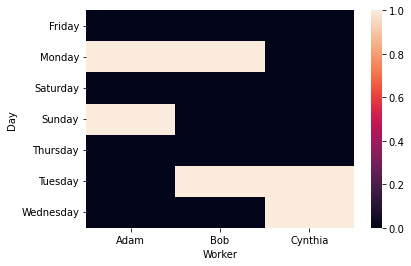

In [11]:
# Worker schedules
sam.plot_worker_schedules(scenario3a)

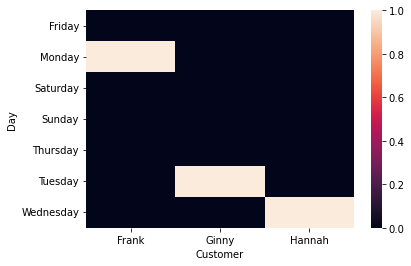

In [12]:
# Customer requests
sam.plot_customer_requests(scenario3a)

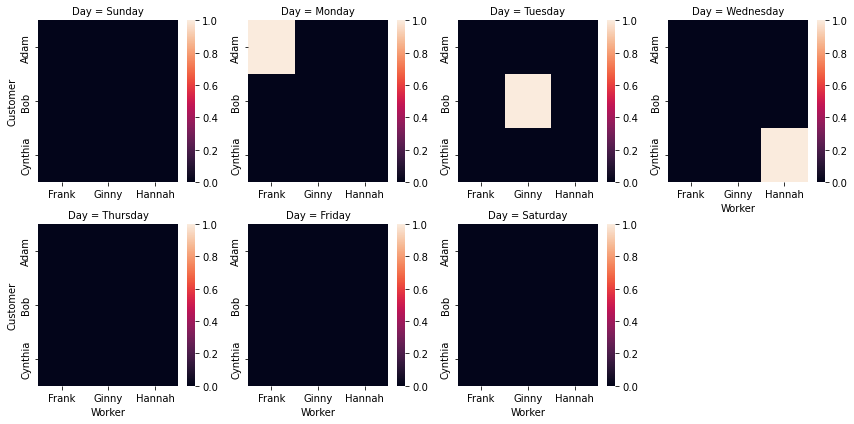

In [13]:
# Customer requests
sam.plot_assignments(scenario3a)